# Summarization trials

## Setup

### Imports

In [1]:
from typing import List, Optional, Union, Any, Tuple
import sys
from loguru import logger
from pathlib import Path 

import numpy as np
import pandas as pd
import plotly.express as px
import torch
import umap
import yaml, json
from langchain import HuggingFaceHub, LLMChain, PromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.schema.document import Document
from langchain.text_splitter import CharacterTextSplitter
from rich import print
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
)

c:\Users\mehdi\miniconda3\envs\ai_news\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append("../")
from src.ai_news_digest.utils import check_gpu_availability, create_run_folder
from src.ai_news_digest.steps.benchmark import entropy

### GPU availability

In [3]:
device = check_gpu_availability()

2024-01-28 20:47:55.311 | INFO     | src.ai_news_digest.utils:check_gpu_availability:49 - Is cuda available ? --> True


_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090 Ti', major=8, minor=6, total_memory=24563MB, 
multi_processor_count=84)

2024-01-28 20:47:55.356 | INFO     | src.ai_news_digest.utils:check_gpu_availability:55 - Chose following device: 'cuda:0'


### Load secrets

In [4]:
with open("../conf/local/credentials.yml", "r") as f:
    hf_secrets = yaml.load(f, Loader=yaml.SafeLoader)["hugging_face"]
hf_hub_token = hf_secrets["hf_hub_token"]

### Config

In [5]:
PATH_INFO_DICT = "../data/03_primary/arxiv_dict_2023-11-06_00-22-42.json"
MODEL_KWARGS = {"device": device}
MODEL_ID = "BAAI/bge-small-en"
ENCODE_KWARGS = {
    "normalize_embeddings": True,
    "batch_size": 16,
    "output_value": "sentence_embedding",
    "convert_to_numpy": True,
    "show_progress_bar": True,
}
UMAP_KWARGS = {
    "n_neighbors": 4,
    "min_dist": 0.05,
    "n_components": 2,
    "metric": "cosine",
}
CLUSTERING_KWARGS = {    
    "min_cluster_size": 5, 
    "min_samples": 3, 
    "max_cluster_size": 30, 
    "cluster_selection_epsilon": 0.05,
}

## Load data

In [6]:
# compute paths
info_path = Path(PATH_INFO_DICT)

# load data (original & translated)
with open(info_path, "r") as f:
    info_dict = json.load(f)["results"]
logger.info(f"Successfully loaded prepared data from : {info_path}")

# retrieve abstracts, titles, dates & paper IDs
df_data = pd.DataFrame(info_dict).transpose()

# display
df_data.head()

2024-01-28 20:47:55.397 | INFO     | __main__:<module>:7 - Successfully loaded prepared data from : ..\data\03_primary\arxiv_dict_2023-11-06_00-22-42.json


,title,abstract,date,category
http://arxiv.org/abs/2311.01425v1,Exploring Deep Learning Techniques for Glaucom...,Glaucoma is one of the primary causes of visio...,2023-11-02 17:39:40+00:00,eess.IV
http://arxiv.org/abs/2311.01352v1,Deep learning based Image Compression for Micr...,With the fast development of modern microscope...,2023-11-02 16:00:32+00:00,eess.IV
http://arxiv.org/abs/2311.01241v1,Exploring Deep Learning Image Super-Resolution...,In this work we test the ability of deep learn...,2023-11-02 13:57:48+00:00,eess.IV
http://arxiv.org/abs/2311.01130v1,A deep learning experiment for semantic segmen...,Palimpsests refer to historical manuscripts wh...,2023-11-02 10:25:47+00:00,cs.CV
http://arxiv.org/abs/2311.01061v1,Deep Learning for real-time neural decoding of...,Neural decoding involves correlating signals a...,2023-11-02 08:26:29+00:00,cs.LG


## Clusterize data

In [7]:
def clustering_pipeline(
    df_embed: pd.DataFrame,
    umap_kwargs: dict,
    clustering_kwargs: Optional[dict]=None,
    random_state: int=123,
    df_data: Optional[pd.DataFrame]=None,
) -> Tuple[pd.DataFrame, Any]:
    
    #--- dimensionality reduction ---

    # instanciate umap projector
    reducer = umap.UMAP(random_state=random_state, **umap_kwargs)

    # project data
    umap_proj = reducer.fit_transform(df_embed)

    # normalize umap coords
    umap_proj = (umap_proj - umap_proj.min(axis=0)) / (umap_proj.max(axis=0) - umap_proj.min(axis=0))

    # store in a dataframe
    df_umap = pd.DataFrame(columns=[f"umap_{i}" for i in range(umap_proj.shape[1])], data=umap_proj)

    # add metadata if available
    if df_data is not None:
        df_umap = pd.concat((df_umap, df_data.reset_index(names=["ID"])), axis=1)

    #--- clustering ---
    if clustering_kwargs is not None:
        X_cluster = df_umap[[col for col in df_umap.columns if "umap" in col]]
        clustering = HDBSCAN(**clustering_kwargs)
        clustering.fit(X_cluster)
        df_umap["cluster"] = [str(elt) for elt in clustering.labels_]
        df_umap["noise"] = [int(elt==-1) for elt in clustering.labels_]

    #--- result ---
    return df_umap, clustering

In [8]:
# load model
hf = HuggingFaceEmbeddings(
    model_name=MODEL_ID,
    model_kwargs={"device": "cpu"},
    encode_kwargs=ENCODE_KWARGS,
)

In [9]:
# compute embeddings
embeddings = np.array(hf.embed_documents(df_data["abstract"]))

# store embeddings in a dataframe
df_embed = pd.DataFrame(
    data=embeddings, 
    columns=[f"embed_{i}" for i in range(embeddings.shape[1])],
    index=df_data.index
)

# display
df_embed.head()

Batches: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
http://arxiv.org/abs/2311.01425v1,-0.001384,-0.009538,0.033621,0.015548,0.049827,0.052703,0.042258,0.009232,-0.011007,-0.016927,...,-0.022196,-0.004897,-0.032707,0.004455,-0.017643,-0.007212,-0.065930,-0.036846,-0.000682,-0.009616
http://arxiv.org/abs/2311.01352v1,-0.002659,-0.010493,0.005734,0.018259,0.056982,0.040098,-0.018745,0.010841,0.017799,0.002271,...,0.024147,-0.013133,-0.048883,0.008194,-0.012212,0.048880,-0.050996,-0.051632,0.037865,-0.019642
http://arxiv.org/abs/2311.01241v1,-0.025940,-0.004279,-0.002302,-0.010307,0.044994,0.062084,-0.002210,0.006609,0.020242,-0.006194,...,-0.006990,-0.019892,-0.021326,-0.021109,0.002532,0.006111,-0.024448,-0.020554,0.012528,-0.004717
http://arxiv.org/abs/2311.01130v1,-0.038666,0.013733,0.005050,0.005592,0.002929,0.026078,-0.004111,-0.005976,0.033418,-0.019905,...,-0.029723,-0.032662,-0.027974,0.000945,0.003917,-0.009779,-0.032067,0.007589,0.006462,-0.008279
http://arxiv.org/abs/2311.01061v1,-0.015999,-0.018669,0.000763,-0.013080,0.023814,0.046864,0.060731,-0.004812,0.036577,-0.033680,...,-0.009631,0.009133,-0.049814,0.008142,-0.012620,0.073099,-0.062735,-0.003177,-0.027720,-0.001277


In [10]:
df_umap, clustering = clustering_pipeline(
    df_embed,
    UMAP_KWARGS,
    CLUSTERING_KWARGS,
    random_state=123,
    df_data=df_data,
)

c:\Users\mehdi\miniconda3\envs\ai_news\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [11]:
df_umap["cluster"] = [str(elt) for elt in clustering.labels_]
df_umap["noise"] = [int(elt==-1) for elt in clustering.labels_]
fig = px.scatter(
    df_umap,
    x="umap_0",
    y="umap_1",
    hover_data=[
        "title",
        "ID",
    ],
    color="cluster",
    symbol="noise",
    # color_continuous_scale=px.colors.qualitative.D3,
    category_orders={"cluster": list(np.sort(pd.unique(clustering.labels_)).astype(str))},
)
fig.show()

In [12]:
df_umap.head(3)

,umap_0,umap_1,ID,title,abstract,date,category,cluster,noise
0,0.892548,0.140247,http://arxiv.org/abs/2311.01425v1,Exploring Deep Learning Techniques for Glaucom...,Glaucoma is one of the primary causes of visio...,2023-11-02 17:39:40+00:00,eess.IV,3,0
1,0.509858,0.417087,http://arxiv.org/abs/2311.01352v1,Deep learning based Image Compression for Micr...,With the fast development of modern microscope...,2023-11-02 16:00:32+00:00,eess.IV,9,0
2,0.519718,0.400701,http://arxiv.org/abs/2311.01241v1,Exploring Deep Learning Image Super-Resolution...,In this work we test the ability of deep learn...,2023-11-02 13:57:48+00:00,eess.IV,9,0


## Summarize a cluster

### Choose one cluster

In [69]:
# choose one cluster
cluster_idx = str(2)

# retrieve data from chosen cluster
df_cluster = df_umap.query("cluster==@cluster_idx").copy()
print(f"Size of cluster n°{cluster_idx}: {df_cluster.shape[0]}")
df_cluster.head(3)

Size of cluster n°5: 24

,umap_0,umap_1,ID,title,abstract,date,category,cluster,noise
31,0.039977,0.298236,http://arxiv.org/abs/2310.19513v1,Inverse folding for antibody sequence design u...,We consider the problem of antibody sequence d...,2023-10-30 13:12:41+00:00,q-bio.BM,5,0
33,0.026125,0.331508,http://arxiv.org/abs/2310.19374v1,Measuring arrangement and size distributions o...,"In microfluidic systems, droplets undergo intr...",2023-10-30 09:29:39+00:00,physics.flu-dyn,5,0
42,0.035350,0.271141,http://arxiv.org/abs/2310.18907v1,"Topological, or Non-topological? A Deep Learni...",Prediction and discovery of new materials with...,2023-10-29 05:29:49+00:00,cond-mat.mtrl-sci,5,0


### Load a model

In [14]:
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline

model_kwargs = {
    "temperature": 0.8,
    "do_sample": True,
    "device": device,
    "torch_dtype": torch.bfloat16,
}


In [16]:
import torch
from transformers import pipeline

# pipe = pipeline("text-generation", model="stabilityai/stablelm-zephyr-3b", trust_remote_code=True, **model_kwargs)
# pipe = pipeline(model="databricks/dolly-v2-3b", torch_dtype=torch.bfloat16, trust_remote_code=True, device_map="auto")
# pipe = pipeline("text-generation", model="Writer/camel-5b-hf")
# pipe = pipeline("text-generation", model="mistralai/Mistral-7B-v0.1", max_new_tokens=250, **model_kwargs)
pipe = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.2", max_new_tokens=250, **model_kwargs)

hf = HuggingFacePipeline(pipeline=pipe)

config.json: 100%|██████████| 596/596 [00:00<?, ?B/s] 
c:\Users\mehdi\miniconda3\envs\ai_news\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mehdi\.cache\huggingface\hub\models--mistralai--Mistral-7B-Instruct-v0.2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development

model.safetensors.index.json: 100%|██████████| 25.1k/25.1k 

In [27]:
# try model/pipeline inference with the `generate` method
hf.pipeline.max_new_tokens = 20
gen = hf.generate(
    ["[INST] Tell me who you are. Answer in less than 50 words.[/INST]"], 
)
print(gen)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


LLMResult(
    generations=[
        [
            Generation(
                text=" I'm an assistant designed to help answer questions, provide information, and complete tasks.
I don't have the ability to feel emotions or form personal relationships, but I'm here to make your life easier."
            )
        ]
    ],
    llm_output=None,
    run=[RunInfo(run_id=UUID('489a080e-509d-41f0-9569-ab502cdff600'))]
)

In [61]:
# try model/pipeline inference with the `predict` method
prompt = """
    <s>[INST] Tell me who you are. Answer in less than 50 words.
    [/INST]
"""

pred = hf.predict(
    prompt, 
)
print(pred)

C:\Users\mehdi\AppData\Roaming\Python\Python310\site-packages\transformers\pipelines\base.py:1101: UserWarning:

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I'm an artificial intelligence designed to assist and communicate with users, answer queries, provide information, 
and perform tasks. I don't have feelings or emotions, but I can process vast amounts of data and learn from 
interactions.

In [62]:
hf.get_num_tokens(pred), len(pred.split(" "))

(44, 36)

### Stuffing

In [70]:
from langchain.chains.summarize import load_summarize_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain.schema.document import Document


docs = [
    Document(
        page_content=f"Article n°{i} -- {row['abstract']}",
        metadata=row.to_dict(),
    )
    for i, row in df_cluster.iterrows()
]

In [71]:
# Define prompt
prompt_template = """<s>[INST]You will be provided with a list of scientific paper abstracts that you must summarize.
Write a concise summary which focuses on the theme of the provided group of papers.
Here is the list of abtracts:
"{text}"
CONCISE SUMMARY: [/INST]"""
prompt = PromptTemplate.from_template(prompt_template)

# Define LLM chain
llm_chain = LLMChain(llm=hf, prompt=prompt)

# Define StuffDocumentsChain
stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

print(stuff_chain.run(docs))

C:\Users\mehdi\AppData\Roaming\Python\Python310\site-packages\transformers\pipelines\base.py:1101: UserWarning:

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


This set of articles explores various applications of advanced technologies such as deep learning, quantum 
computing, and machine learning in different scientific fields. Some articles focus on improving the accuracy and 
efficiency of material discovery, while others investigate the behavior of fluids in microchannels or the 
reconstruction of the spatio-temporal dynamics of gas-liquid interfaces. There are also studies on enhancing the 
performance of quantum chemical property prediction models and the use of neural networks for automatic model 
discovery in material modeling. Overall, these articles highlight the potential of innovative technologies to 
address complex scientific challenges and push the boundaries of current knowledge.

In [72]:
print(df_cluster.abstract.values.tolist())

[
    'We consider the problem of antibody sequence design given 3D structural\ninformation. Building on previous 
work, we propose a fine-tuned inverse folding\nmodel that is specifically optimised for antibody structures and 
outperforms\ngeneric protein models on sequence recovery and structure robustness when\napplied on antibodies, with
notable improvement on the hypervariable CDR-H3\nloop. We study the canonical conformations of 
complementarity-determining\nregions and find improved encoding of these loops into known clusters. Finally,\nwe 
consider the applications of our model to drug discovery and binder design\nand evaluate the quality of proposed 
sequences using physics-based methods.',
    'In microfluidic systems, droplets undergo intricate deformations as they\ntraverse flow-focusing junctions, 
posing a challenging task for accurate\nmeasurement, especially during short transit times. This study investigates
the\nphysical behavior of droplets within dense emulsions in diverse microchannel\ngeometries, specifically 
focusing on the impact of varying opening angles\nwithin the primary channel and injection rates of fluid 
components. Employing a\nsophisticated droplet tracking tool based on deep-learning techniques, we\nanalyze 
multiple frames from flow-focusing experiments to quantitatively\ncharacterize droplet deformation in terms of 
ratio between maximum width and\nheight and propensity to form liquid with hexagonal crystalline order. 
Our\nfindings reveal the existence of an optimal opening angle where shape\ndeformations are minimal and 
crystal-like arrangement is maximal. Variations of\nfluid injection rates are also found to affect size and packing
fraction of the\nemulsion in the exit channel. This paper offers insights into deformations,\nsize and structure of
fluid emulsions relative to microchannel geometry and\nother flow-related parameters captured through machine 
learning, with potential\nimplications for the design of microchips utilized in cellular transport and\ntissue 
engineering applications.',
    'Prediction and discovery of new materials with desired properties are at the\nforefront of quantum science and
technology research. A major bottleneck in\nthis field is the computational resources and time complexity related 
to\nfinding new materials from ab initio calculations. In this work, an effective\nand robust deep learning-based 
model is proposed by incorporating persistent\nhomology and graph neural network which offers an accuracy of 91.4% 
and an F1\nscore of 88.5% in classifying topological vs. non-topological materials,\noutperforming the other 
state-of-the-art classifier models. The incorporation\nof the graph neural network encodes the underlying relation 
between the atoms\ninto the model based on their own crystalline structures and thus proved to be\nan effective 
method to represent and process non-euclidean data like molecules\nwith a relatively shallow network. The 
persistent homology pipeline in the\nsuggested neural network is capable of integrating the 
atom-specific\ntopological information into the deep learning model, increasing robustness,\nand gain in 
performance. It is believed that the presented work will be an\nefficacious tool for predicting the topological 
class and therefore enable the\nhigh-throughput search for novel materials in this field.',
    "Electrical Impedance Tomography (EIT) is a powerful imaging technique with\ndiverse applications, e.g., 
medical diagnosis, industrial monitoring, and\nenvironmental studies. The EIT inverse problem is about inferring 
the internal\nconductivity distribution of an object from measurements taken on its boundary.\nIt is severely 
ill-posed, necessitating advanced computational methods for\naccurate image reconstructions. Recent years have 
witnessed significant\nprogress, driven by innovations in analytic-based approaches and deep learning.\nThis review
explores techniques for solving the EIT inverse problem

Raw stuffing took 5min for cluster n°5
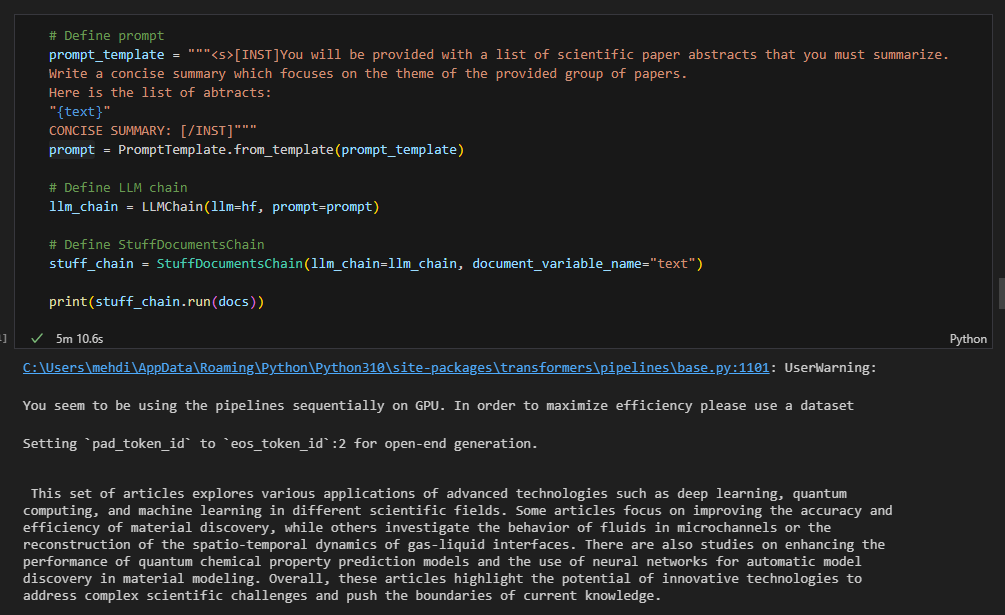

### [WIP] Resursive adaptive-window stuffing

In [68]:
df_cluster = df_umap.query("cluster=='5'").copy()
print(f"Size of cluster n°{cluster_idx}: {df_cluster.shape[0]}")
df_cluster.head(2)

Size of cluster n°2: 24

,umap_0,umap_1,ID,title,abstract,date,category,cluster,noise
31,0.039977,0.298236,http://arxiv.org/abs/2310.19513v1,Inverse folding for antibody sequence design u...,We consider the problem of antibody sequence d...,2023-10-30 13:12:41+00:00,q-bio.BM,5,0
33,0.026125,0.331508,http://arxiv.org/abs/2310.19374v1,Measuring arrangement and size distributions o...,"In microfluidic systems, droplets undergo intr...",2023-10-30 09:29:39+00:00,physics.flu-dyn,5,0


In [66]:
prompt

PromptTemplate(input_variables=['text'], template='<s>[INST]You will be provided with a list of scientific paper abstracts that you must summarize.\nWrite a concise summary which focuses on the theme of the provided group of papers.\nHere is the list of abtracts:\n"{text}"\nCONCISE SUMMARY: [/INST]')

In [67]:
prompt_template

'<s>[INST]You will be provided with a list of scientific paper abstracts that you must summarize.\nWrite a concise summary which focuses on the theme of the provided group of papers.\nHere is the list of abtracts:\n"{text}"\nCONCISE SUMMARY: [/INST]'

In [ ]:
def summarize(
    hf_pipe: HuggingFacePipeline, 
    prompt_template: str,
    docs: List[Document],
) -> str:
    
    # define Stuff chain
    prompt = PromptTemplate.from_template(prompt_template)
    llm_chain = LLMChain(llm=hf_pipe, prompt=prompt)
    stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

    # TODO: sort documents based on their distance to O (origin)


    # get max sequence length
    # TODO: check this value is valid and functional 
    # --> https://github.com/huggingface/transformers/blob/f1cc6157210abd9ea953da097fb704a1dd778638/src/transformers/models/mistral/configuration_mistral.py#L63 
    Lt_max = hf_pipe.pipeline.model.config.max_position_embeddings

    # compute number of promt tokens
    Lt_prompt = hf_pipe.get_num_tokens(prompt_template)

    # compute nmber of tokens for docs
    Lt_docs_list = [hf_pipe.get_num_tokens(doc.page_content) for doc in docs]
    Lt_docs = np.sum(Lt_docs_list)
    
    # end case
    # TODO: check if this context_length is valid
    if Lt_docs + Lt_prompt <= Lt_max:
        return stuff_chain.run(docs)
    
    else:

        news_docs = []
        j1, j2 = 0, 1

        while j1 < len(docs) and j2 < len(docs):

            if np.sum(Lt_docs_list[j1:j2+1])


    

In [137]:
hf.pipeline.model.config.max_position_embeddings

32768

In [106]:
32768, 32 * 1024

(32768, 32768)

In [116]:
hf.pipeline.model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  

In [132]:
from rich import inspect
# inspect(hf.pipeline.model.model.layers[0].self_attn)
inspect(hf.pipeline.model)



╭─ MistralForCausalLM(   (model): MistralModel(     (embed_tokens): Embedding(32000, 4096)     (layers): ModuleLi─╮
│ def (*args, **kwargs):                                                                                          │
│                                                                                                                 │
│               base_model_prefix = 'model'                                                                       │
│                 call_super_init = False                                                                         │
│                          config = MistralConfig {                                                               │
│                                     "_name_or_path": "mistralai/Mistral-7B-Instruct-v0.2",                      │
│                                     "architectures": [                                                          │
│                                       "MistralForCausalLM"                                                      │
│                                     ],                                                                          │
│                                     "attention_dropout": 0.0,                                                   │
│                                     "bos_token_id": 1,                                                          │
│                                     "eos_token_id": 2,                                                          │
│                                     "hidden_act": "silu",                                                       │
│                                     "hidden_size": 4096,                                                        │
│                                     "initializer_range": 0.02,                                                  │
│                                     "intermediate_size": 14336,                                                 │
│                                     "max_position_embeddings": 32768,                                           │
│                                     "model_type": "mistral",                                                    │
│                                     "num_attention_heads": 32,                                                  │
│                                     "num_hidden_layers": 32,                                                    │
│                                     "num_key_value_heads": 8,                                                   │
│                                     "rms_norm_eps": 1e-05,                                                      │
│                                     "rope_theta": 1000000.0,                                                    │
│                                     "sliding_window": null,                                                     │
│                                     "tie_word_embeddings": false,                                               │
│                                     "torch_dtype": "bfloat16",                                                  │
│                                     "transformers_version": "4.36.2",                                           │
│                                     "use_cache": true,                                                          │
│                                     "vocab_size": 32000                                                         │
│                                   }                                                                             │
│                          device = device(type='cuda', index=0)                                                  │
│                           dtype = torch.bfloat16                                                                │
│                    dummy_inputs = {                                                                             │
│                                       'input_ids': ten